In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import pydicom
import glob

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

### Table of content:

* [Loading data](#Loading-data)
* [Variables Info](#Variables-Info)
- [Preprocessing](#Preprocessing)
    - [Renaming columns](#Renaming-columns)
    - [Getting classes from labels](#Getting-classes-from-labels)
- [Age distribution](#Age-distribution)
* [Most frequent diseases with Pneumonia](#Most-frequent-diseases-with-Pneumonia)
- [Number of diseases per patient](#Number-of-diseases-per-patient)
* [Pixel level assessments](#Pixel-level-assessments)
* [Dicoms](#Dicoms)
* [Conclusions](#Conclusions)

---

# Loading data

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1224,00006462_010.png,Atelectasis|Effusion,10,6462,060Y,F,AP,2500,2048,0.168,0.168
4353,00021494_018.png,Effusion|Infiltration,18,21494,038Y,F,AP,3056,2544,0.139,0.139
682,00003523_012.png,Infiltration,12,3523,023Y,F,AP,2500,2048,0.168,0.168


In [3]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
1097,00000270_002.png,Atelectasis,2,270,52,F,PA,2500,2048,0.168,0.168,NaN
107004,00028876_008.png,No Finding,8,28876,40,M,AP,3056,2544,0.139,0.139,NaN
55986,00013993_042.png,Edema|Effusion,42,13993,42,M,AP,2500,2048,0.168,0.168,NaN


In [4]:
all_xray_df.shape, sample_df.shape

((112120, 12), (5606, 11))

## Variables Info

In [5]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [6]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Preprocessing

### Renaming columns

In [7]:
## rennamed the columns for facility
all_xray_df.columns = ['image_index', 'finding_labels', 'follow_up', 'patient_id',
       'age', 'gender', 'view_position', 'width',  'height', 'pixel_x', 'pixel_y', 'unnamed']

In [8]:
## I deleted this column, which is not used in the analysis
del all_xray_df["unnamed"]

### Getting classes from labels
We extracte names of diseases founded with Pneumonia from the variable `finding_labes`

In [9]:
all_labels = np.unique(list(chain(*all_xray_df['finding_labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['finding_labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
98621,00026073_005.png,No Finding,5,26073,56,F,PA,1795,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105032,00028184_001.png,No Finding,1,28184,21,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65062,00016062_000.png,No Finding,0,16062,55,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Number of patients

In [10]:
all_xray_df.patient_id.nunique()

30805

## Number of cases

- number of pneumonia cases
- number of non-pneumonia cases

In [38]:
np.round(all_xray_df.Pneumonia.value_counts(normalize =True).to_frame()*100, 2)

,Pneumonia
0.0,98.72
1.0,1.28


In [ ]:
The pneumonia cases are only 1.28% of the total cases, which is about

## Age distribution

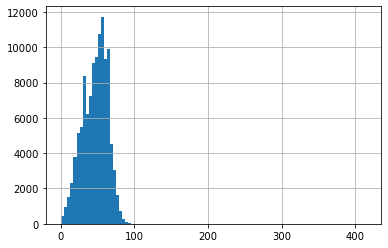

In [13]:
all_xray_df.age.hist(bins = 100)

> There are values greater than 100 which is really strange, I assume those are not reliable values, so I dropped them.

In [21]:
all_xray_df[all_xray_df.age<100].shape

(112104, 26)

In [42]:
all_xray_df = all_xray_df[all_xray_df.age<100]

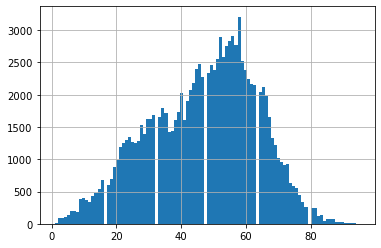

In [23]:
all_xray_df.age.hist(bins = 100)

***

### At what age pneumonia mostly affects?

The cases with pneumonia follow nearly the same age's distribution as the cases without pneumonia.
* the age is well distributed around 50 years old in average, 
* Notice there are values close to zero, which I have to validate those images belongs to babies or kids.

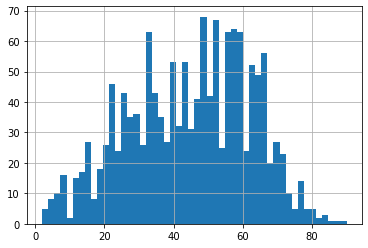

In [31]:
all_xray_df[all_xray_df.Pneumonia == 1].age.hist(bins = 50)

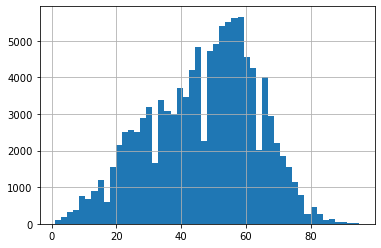

In [32]:
all_xray_df[all_xray_df.Pneumonia == 0].age.hist(bins = 50)

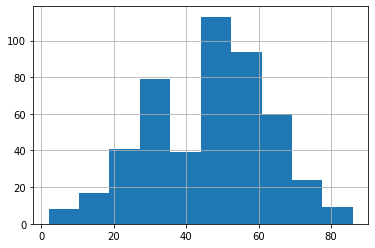

In [27]:
all_xray_df[all_xray_df.finding_labels == 'Cardiomegaly|Effusion'].age.hist()

---

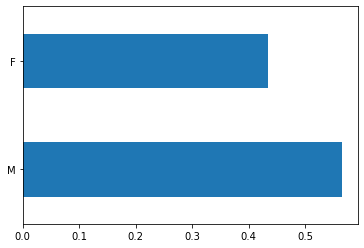

In [25]:
all_xray_df.gender.value_counts(normalize = True).plot(kind = "barh")

### Age distribution by sex

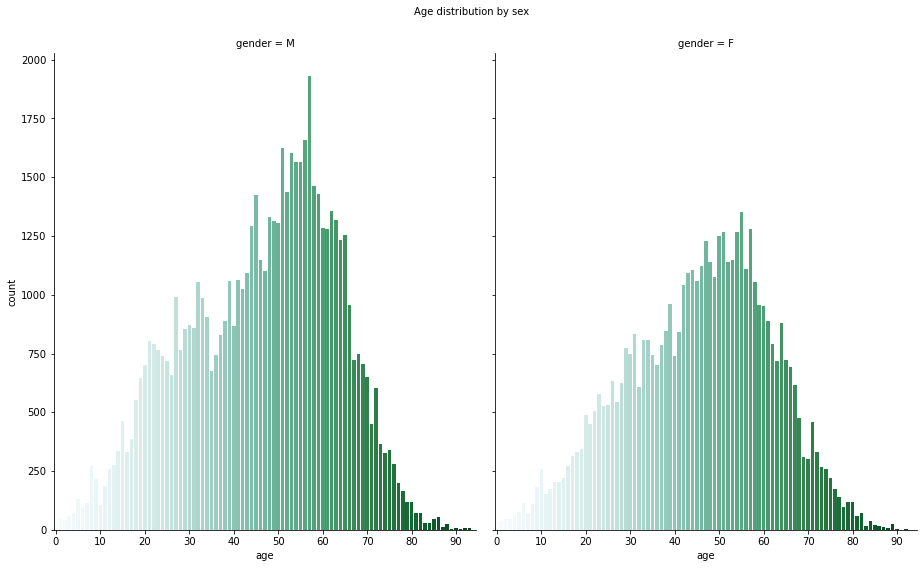

In [88]:
g = sns.catplot(x = "age", col = "gender", data = all_xray_df, kind = "count", size = 8
                aspect = 0.8,palette = "BuGn", sharex=False, height=6);

g.set_xticklabels(np.arange(0, 100));
g.set_xticklabels(step = 10);

g.fig.suptitle('Age distribution by sex', fontsize = 10);
g.fig.subplots_adjust(top = .9)

### Age per disease

- Emphysema depicts more volumen of female patients
- Cardiomegaly seems to be a bimodal distributions one mean between25 -35 years and the other between  55 - 70
-  Hernia only have patients with less than 50 years old.

In [97]:
diseases_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',   'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax', "Pneumonia"]

In [98]:
len(diseases_labels)

14

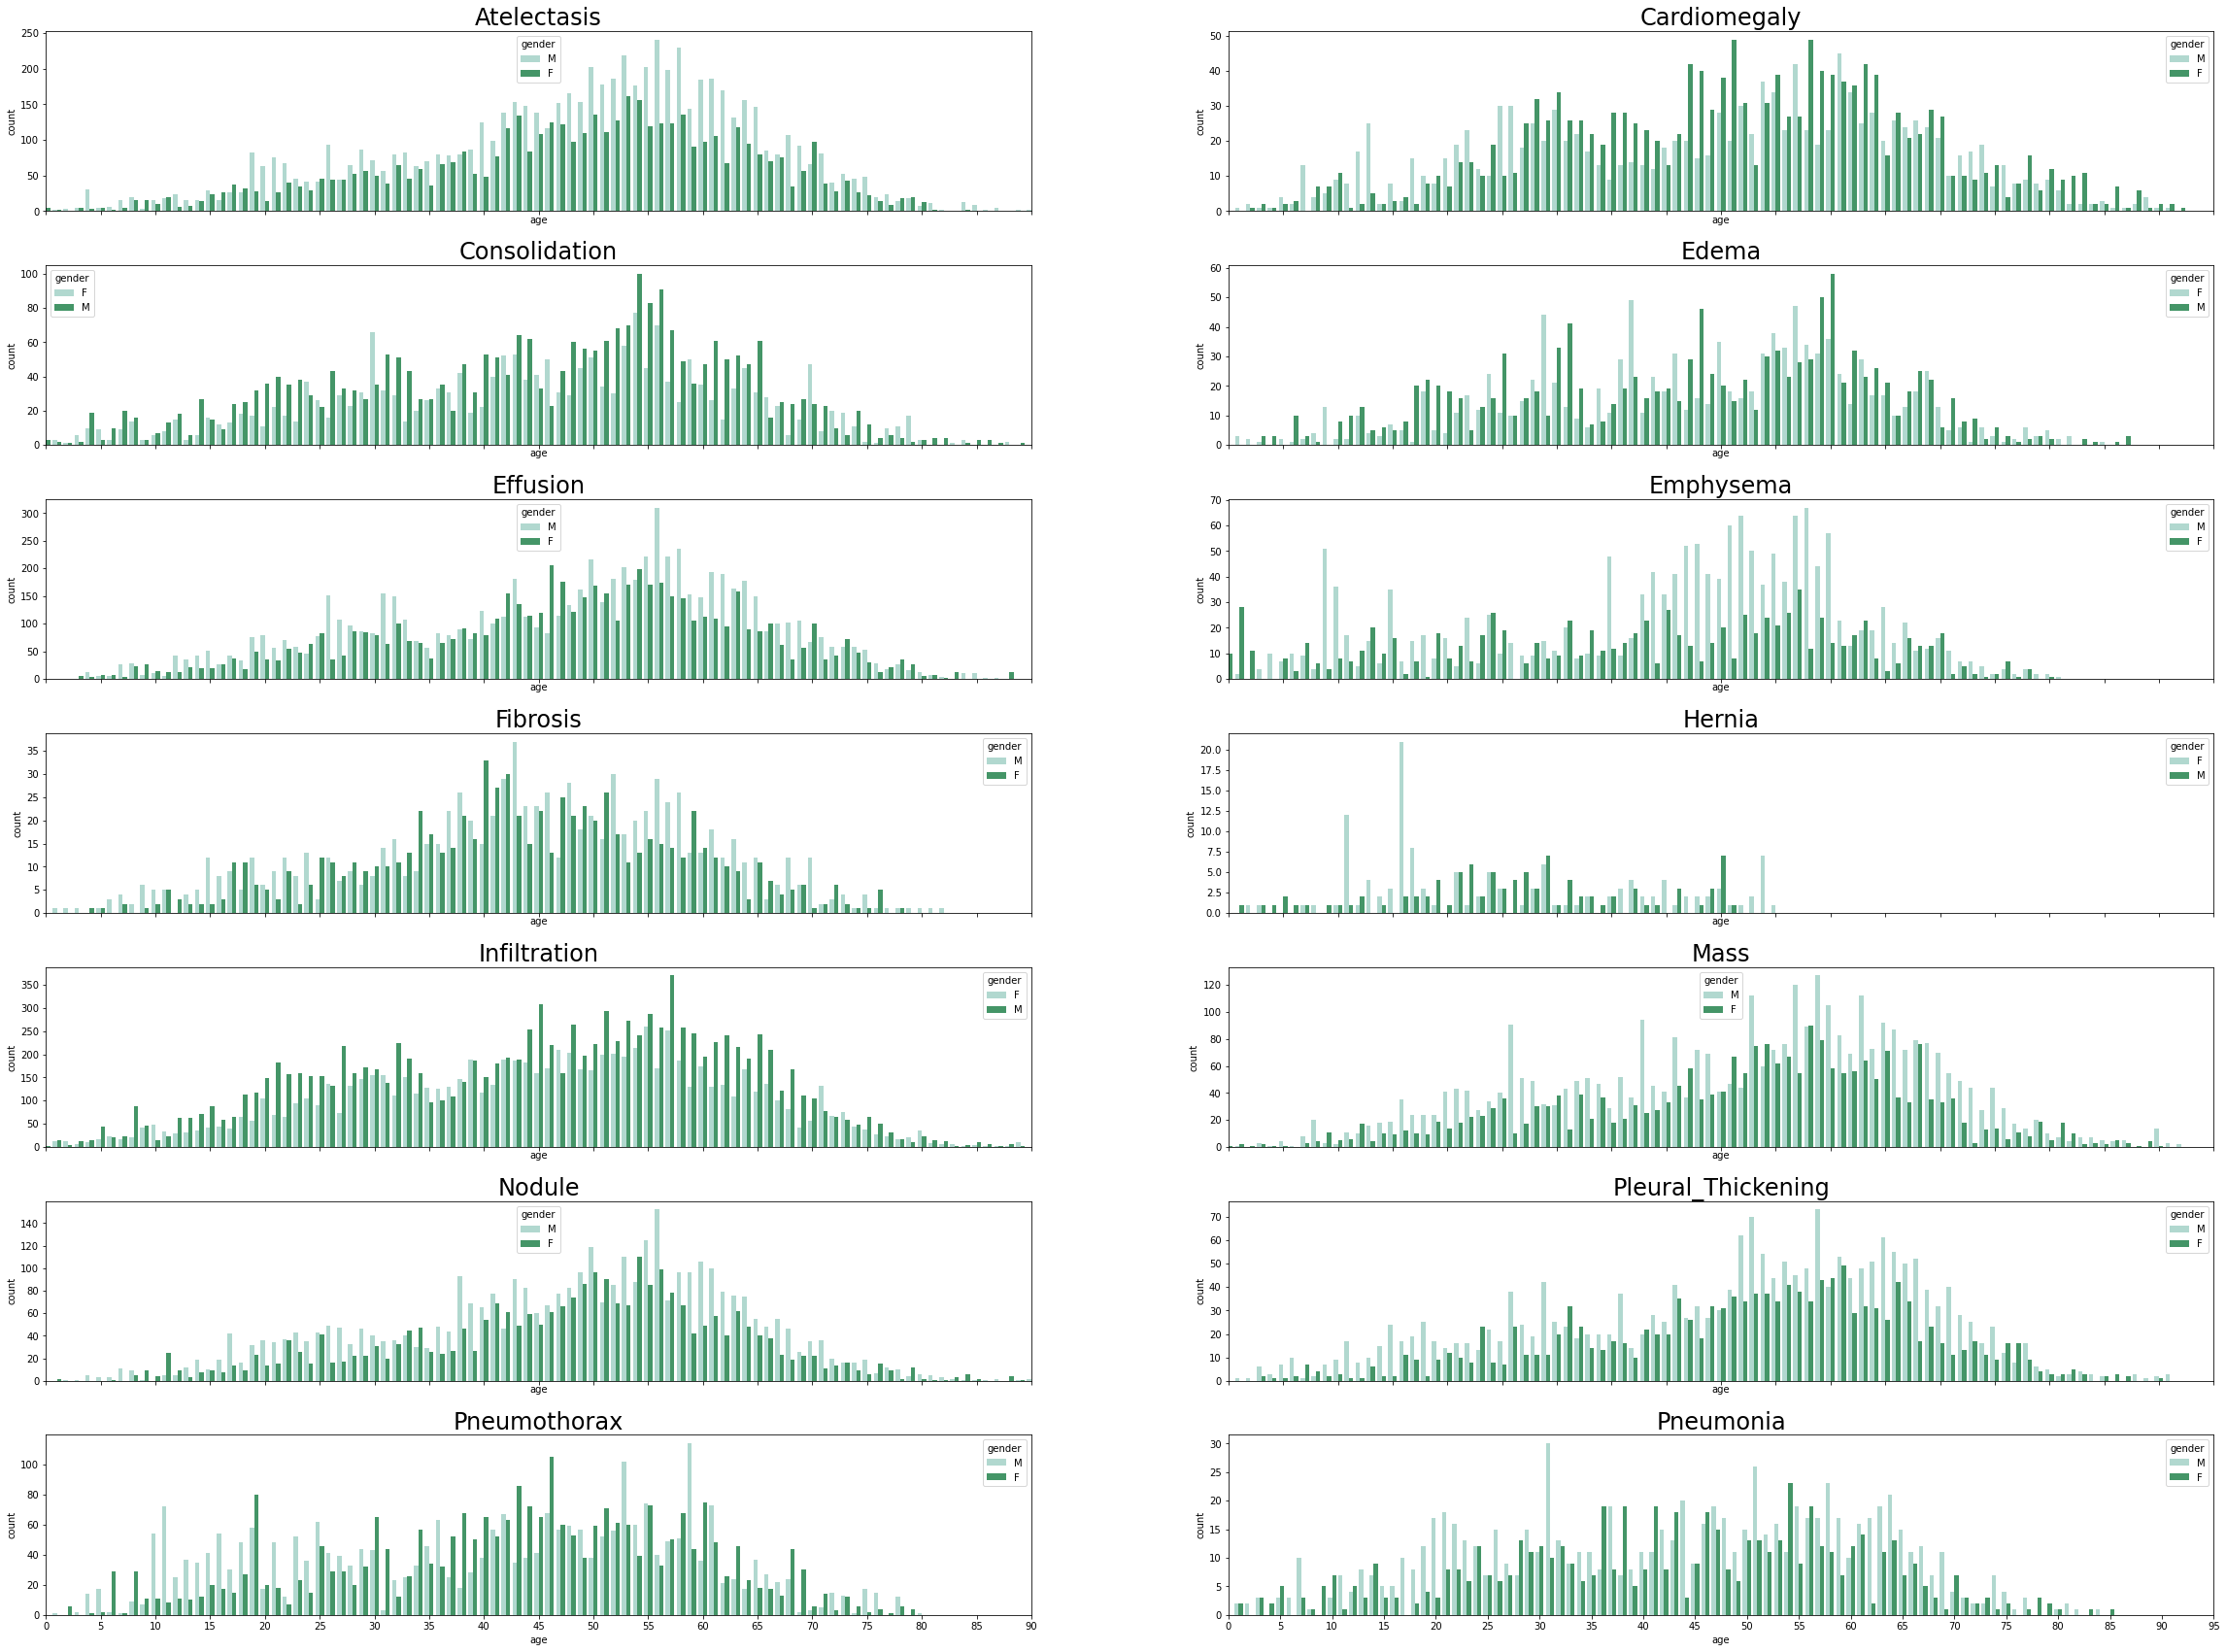

In [127]:
from itertools import cycle

fig, axs = plt.subplots(7, 2, figsize = (40, 30), sharey=False, sharex=True)
axs = axs.flatten()
ax_idx = 0

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
col = 0  
x = np.arange(0, 100, 5)

for disease in diseases_labels:
    dftmp_plot = all_xray_df[all_xray_df[disease] == 1].copy()
    height  = 20
    width   = 20
    
    g = sns.countplot(x = "age", hue = "gender", data = dftmp_plot, palette = "BuGn",  ax = axs[ax_idx]);  
    g.set_xlim(0, 90)
    g.set_title("{}".format(disease), fontsize = 24)
    
    g.set_xticks(x)
    g.set_xticklabels(x)

    ax_idx += 1

fig.subplots_adjust(hspace = 0.3)

### Follow up per disease

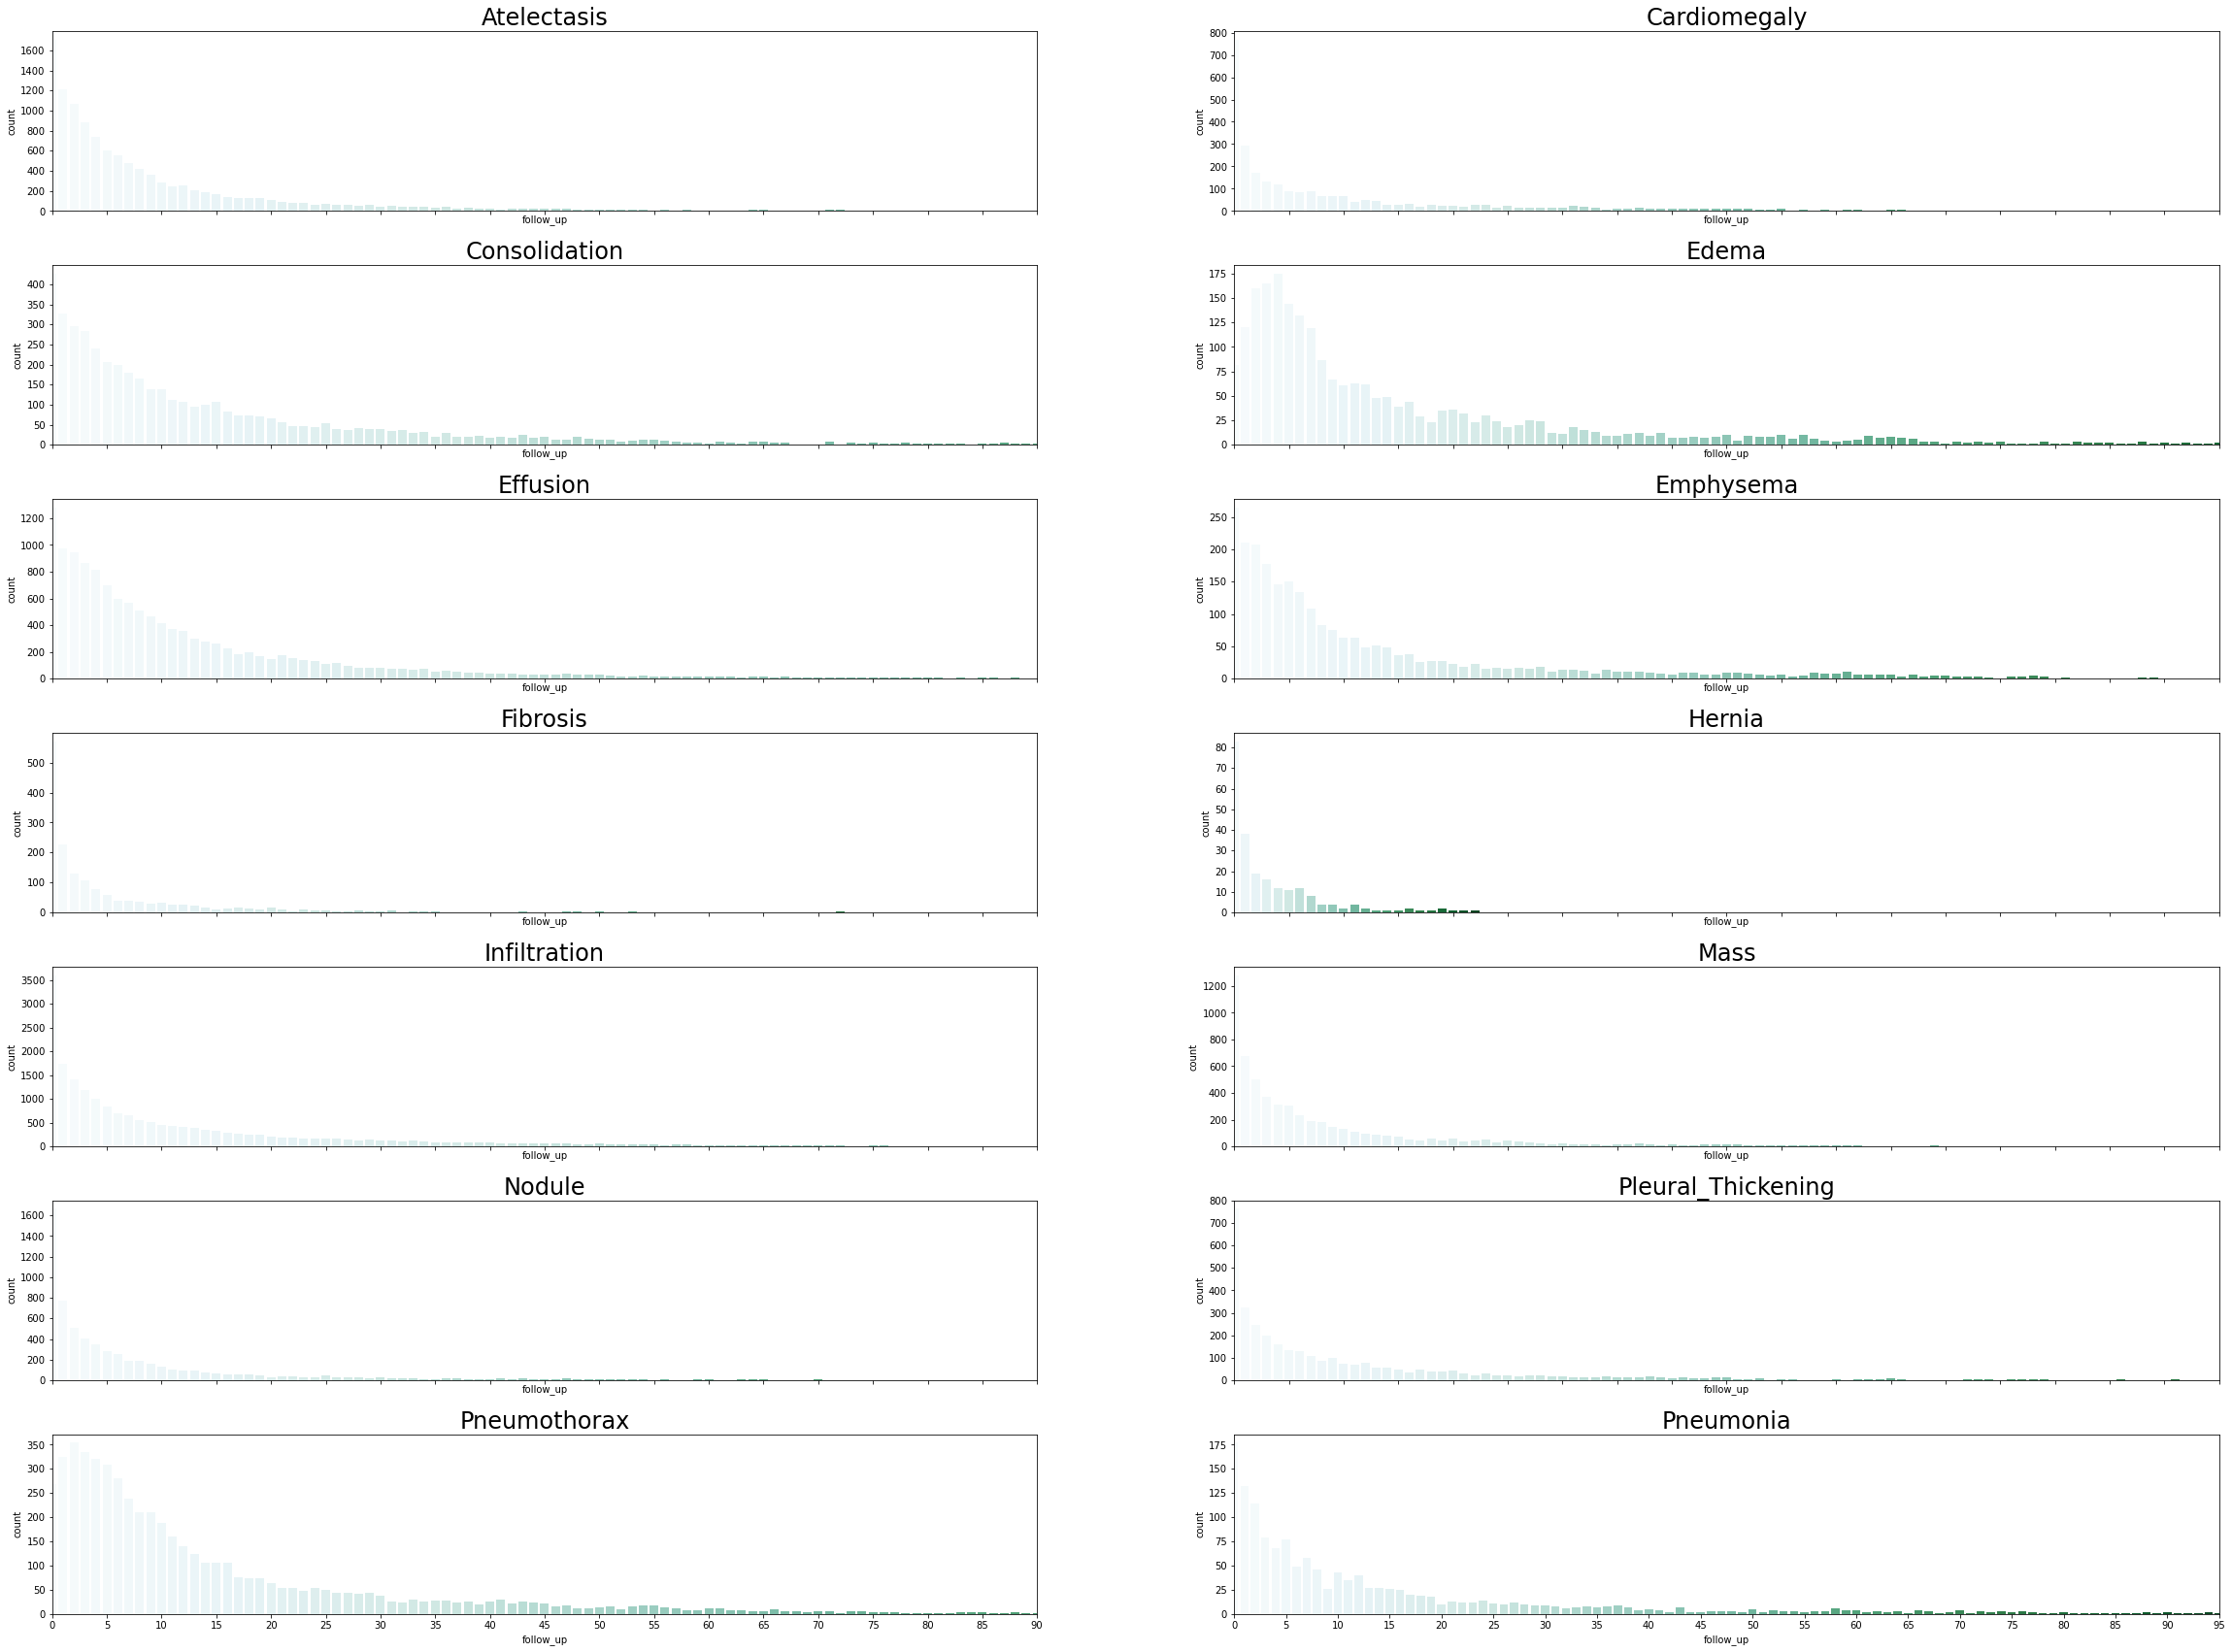

In [129]:
from itertools import cycle

fig, axs = plt.subplots(7, 2, figsize = (40, 30), sharey=False, sharex=True)
axs = axs.flatten()
ax_idx = 0

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
col = 0  
x = np.arange(0, 100, 5)

for disease in diseases_labels:
    dftmp_plot = all_xray_df[all_xray_df[disease] == 1].copy()
    height  = 20
    width   = 20
    
    g = sns.countplot(x = "follow_up",  data = dftmp_plot, palette = "BuGn",  ax = axs[ax_idx]);  
    g.set_xlim(0, 90)
    g.set_title("{}".format(disease), fontsize = 24)
    
    g.set_xticks(x)
    g.set_xticklabels(x)

    ax_idx += 1

fig.subplots_adjust(hspace = 0.3)

### Most frequent diseases with Pneumonia

[Text(0, 0.5, 'Number of Images with Label')]

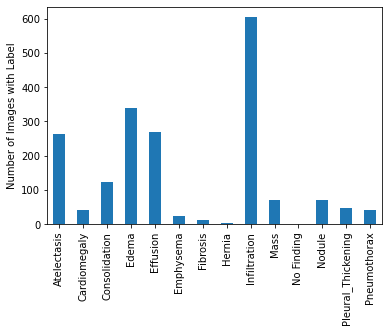

In [19]:
all_labels.remove("Pneumonia")
ax = all_xray_df.loc[all_xray_df.Pneumonia == 1, all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The most frequent are Atelectasis, Edema and Infiltration.
- Infiltration: Infiltration is the diffusion or accumulation (in a tissue or cells) of foreign substances or in amounts in excess of the normal.
- Edema:  is a condition caused by excess fluid in the lungs. 
- Atelectasis: is a complete or partial collapse of the entire lung or area (lobe) of the lung. It occurs when the tiny air sacs (alveoli) within the lung become deflated or possibly filled with alveolar fluid.

## Number of diseases per patient

Most of the patient don't have any disease register.
- About 30% of the patient has only one disease.
- ~18% have more than 2 diseases registered.

In [64]:
all_xray_df["n_diseases"] = all_xray_df.loc[:, diseases_labels].sum(axis = 1)
df_disease_patient = all_xray_df.n_diseases.value_counts(normalize = True).to_frame().sort_values("n_diseases", ascending = True)

In [70]:
df_disease_patient[df_disease_patient.n_diseases<0.13].n_diseases.sum()

0.18547063441090414

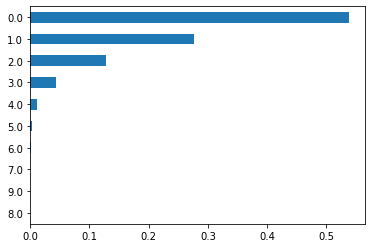

In [73]:
df_disease_patient.n_diseases.plot(kind = "barh")

### View taken

In [49]:
pd.concat([all_xray_df.view_position.value_counts(), all_xray_df.view_position.value_counts(normalize =True)*100], axis=1)

,view_position,view_position
PA,67299,60.032648
AP,44805,39.967352


In [52]:
all_xray_df.head()

,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
dfgroup_viewposition = all_xray_df.groupby("patient_id")["view_position"].value_counts().to_frame()
dfgroup_viewposition.columns = ["counting"]
dfgroup_viewposition.reset_index(inplace=True)

In [61]:
dfgroup_viewposition.groupby("view_position").agg({'counting':[np.mean, np.max]})

counting     
                   mean amax
view_position               
AP             4.945364  183
PA             2.331590  100

## Pixel level assessments

In [3]:
sample_df.columns = ['image_index', 'finding_labels', 'follow_up', 'patient_id',
       'age', 'gender', 'view_position', 'width',  'height', 'pixel_x', 'pixel_y']

In [4]:
all_labels = np.unique(list(chain(*sample_df['finding_labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        sample_df[c_label] = sample_df['finding_labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3570,00017641_008.png,Consolidation|Effusion|Infiltration|Mass,8,17641,067Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
87,00000490_000.png,Infiltration,0,490,058Y,M,PA,2898,2851,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1946,00010123_003.png,Pneumothorax,3,10123,025Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
len(all_labels)

15

In [16]:
from glob import glob
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images_*', '*', '*.png'))}
sample_df['path_img'] = sample_df['image_index'].map(paths_img.get)

In [21]:
hist.head()

,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path_img
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_004/images/00008470_008.png
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_006/images/00011702_043.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_006/images/00012158_025.png
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_006/images/00012667_000.png
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_006/images/00012733_000.png


In [24]:
hist.shape

(62, 27)

In [22]:
dffilter = sample_df[sample_df["Pneumonia"]==1]
data = []
for p in range(9):
    data.append(("pneumonia", dffilter.iloc[p]["path_img"]))

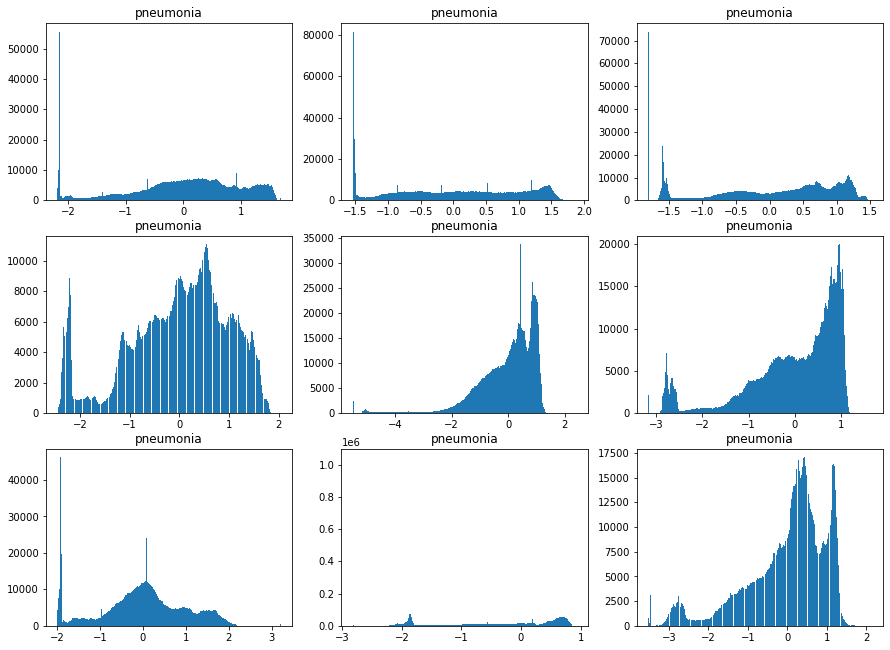

In [23]:
plt.figure(figsize=(15, 15))
columns = 3

for i in range(len(data)):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumonia')
    img_set = plt.imread(data[i][1])
    
    plt.hist(((img_set - np.mean(img_set))/np.std(img_set)).ravel(), bins=250)

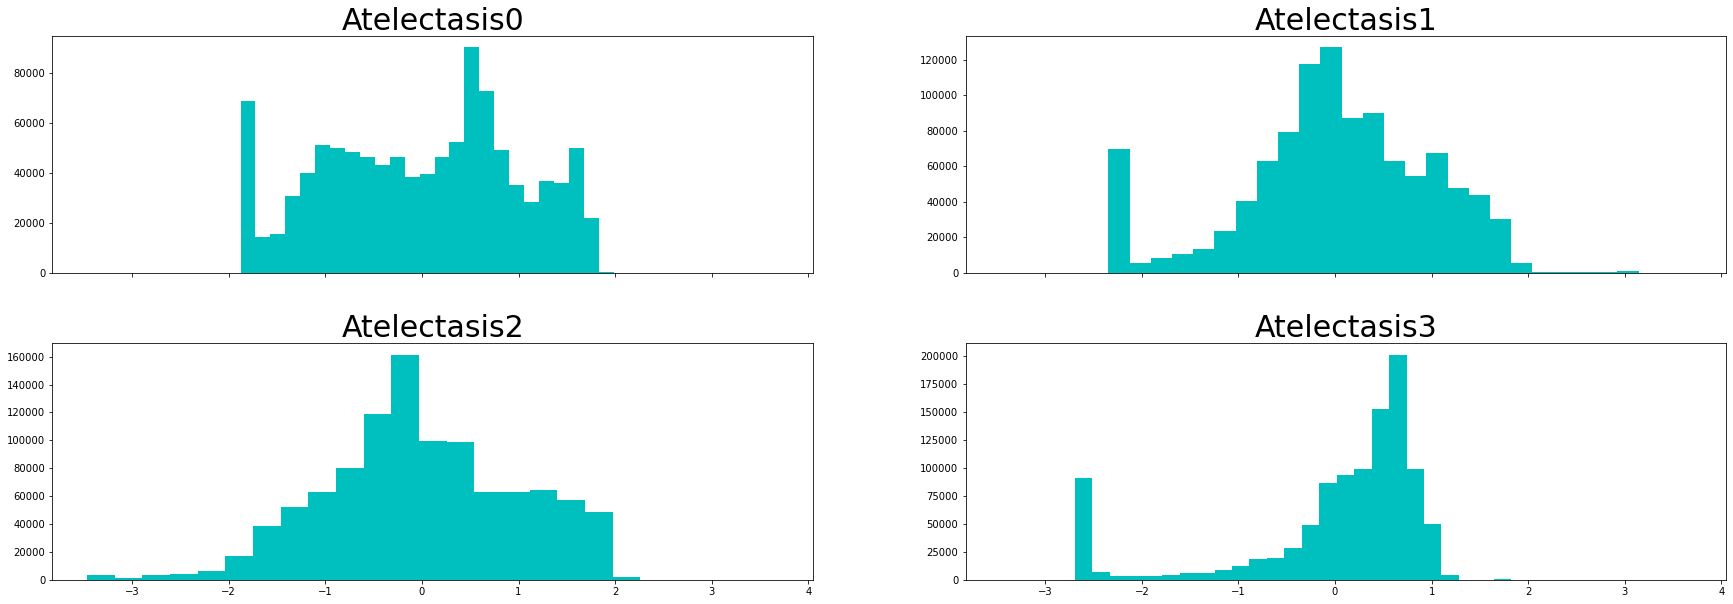

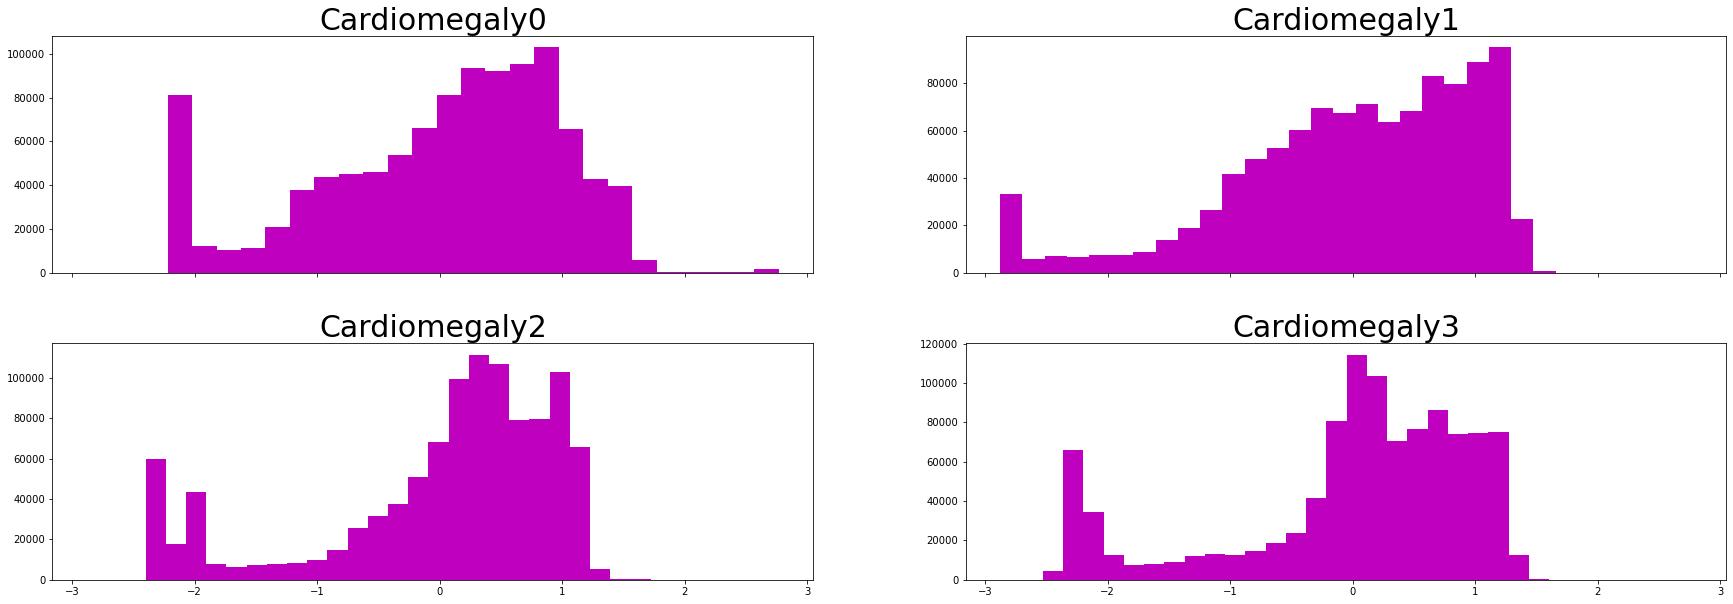

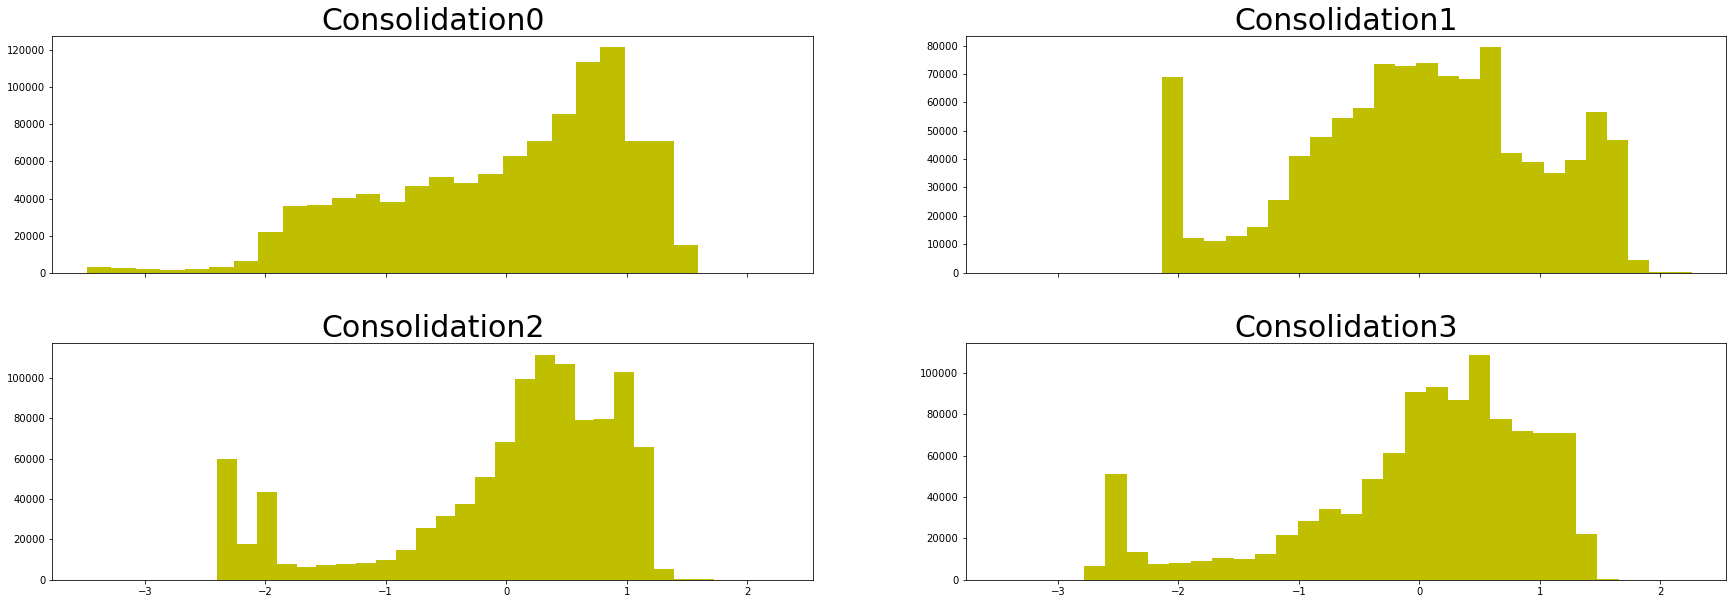

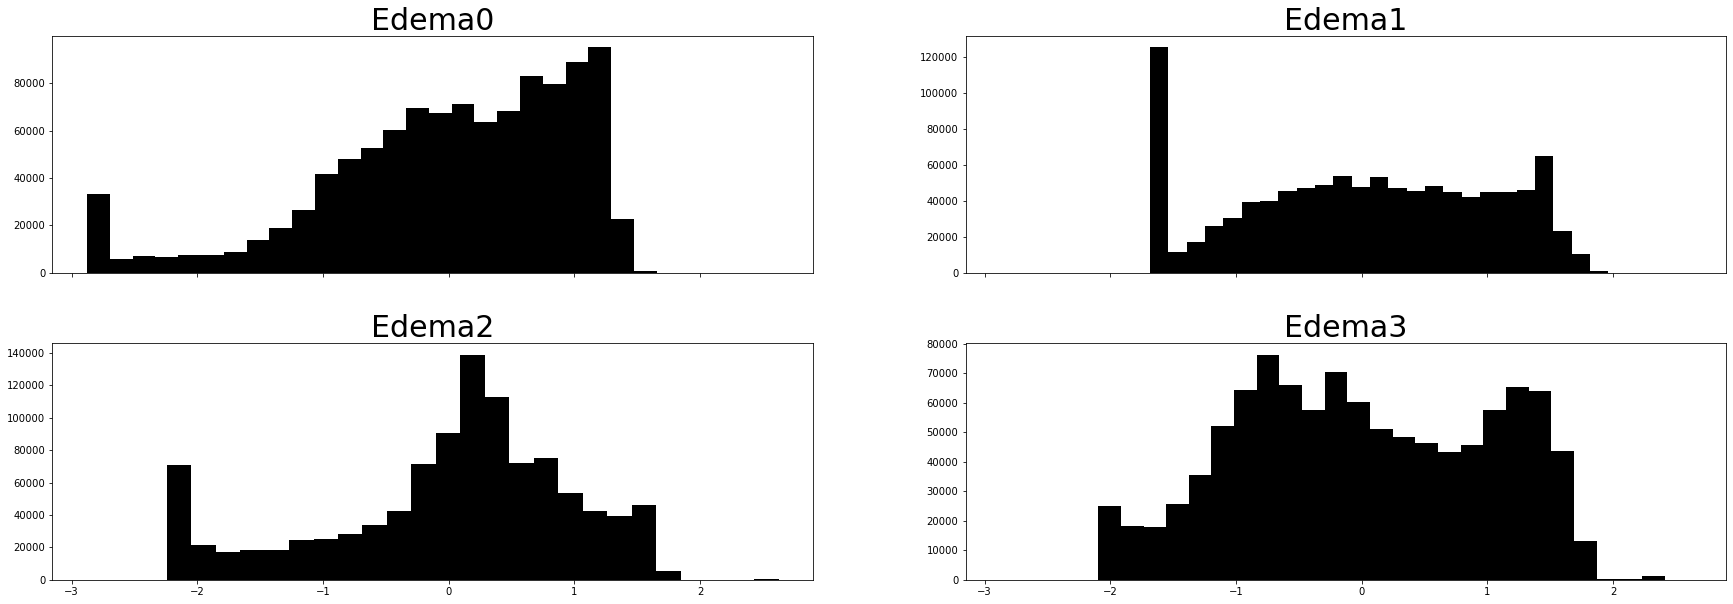

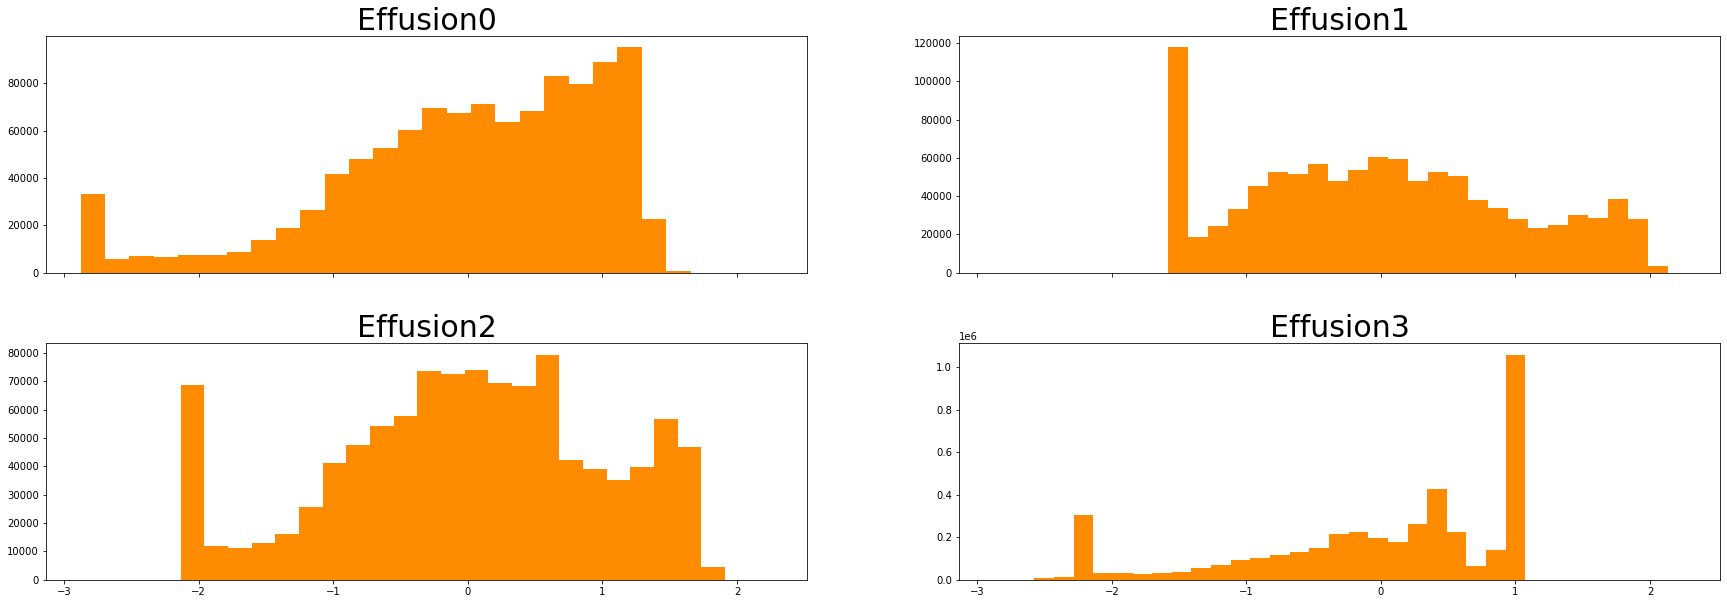

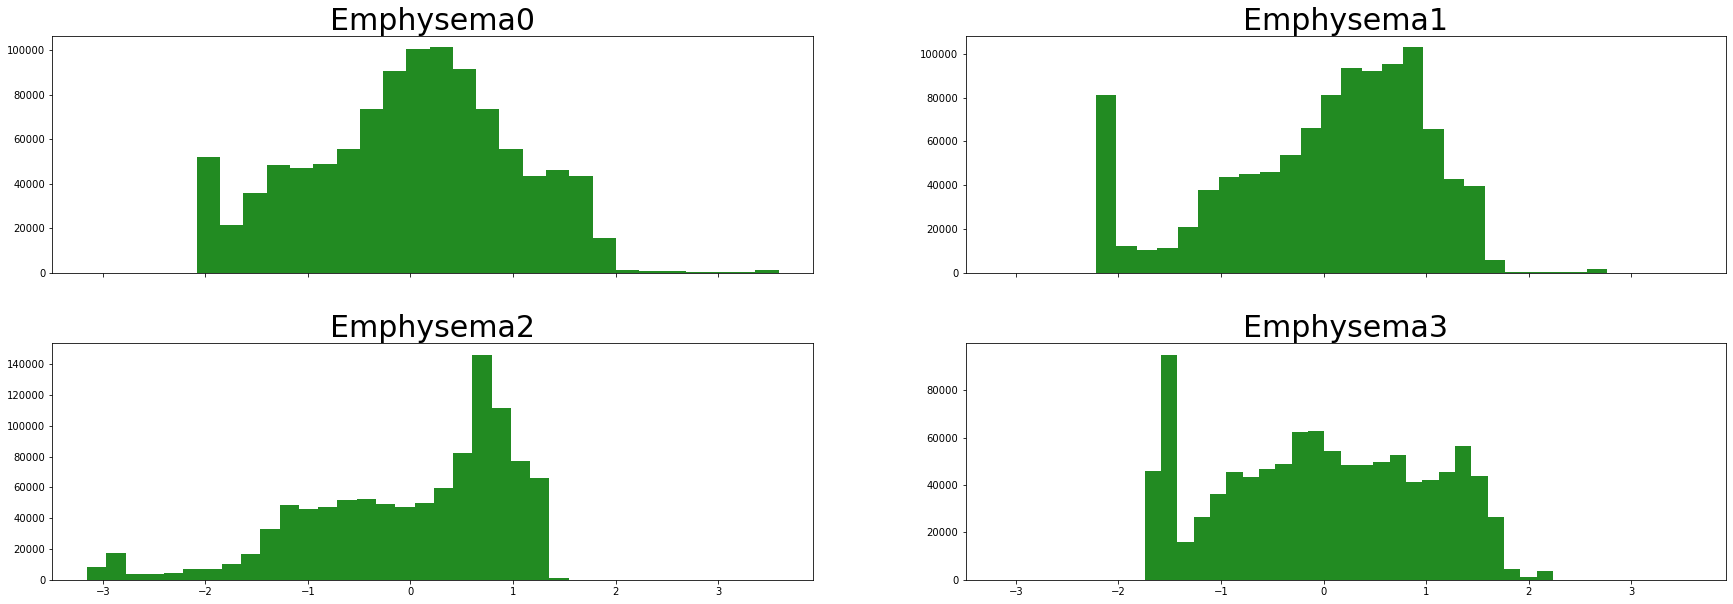

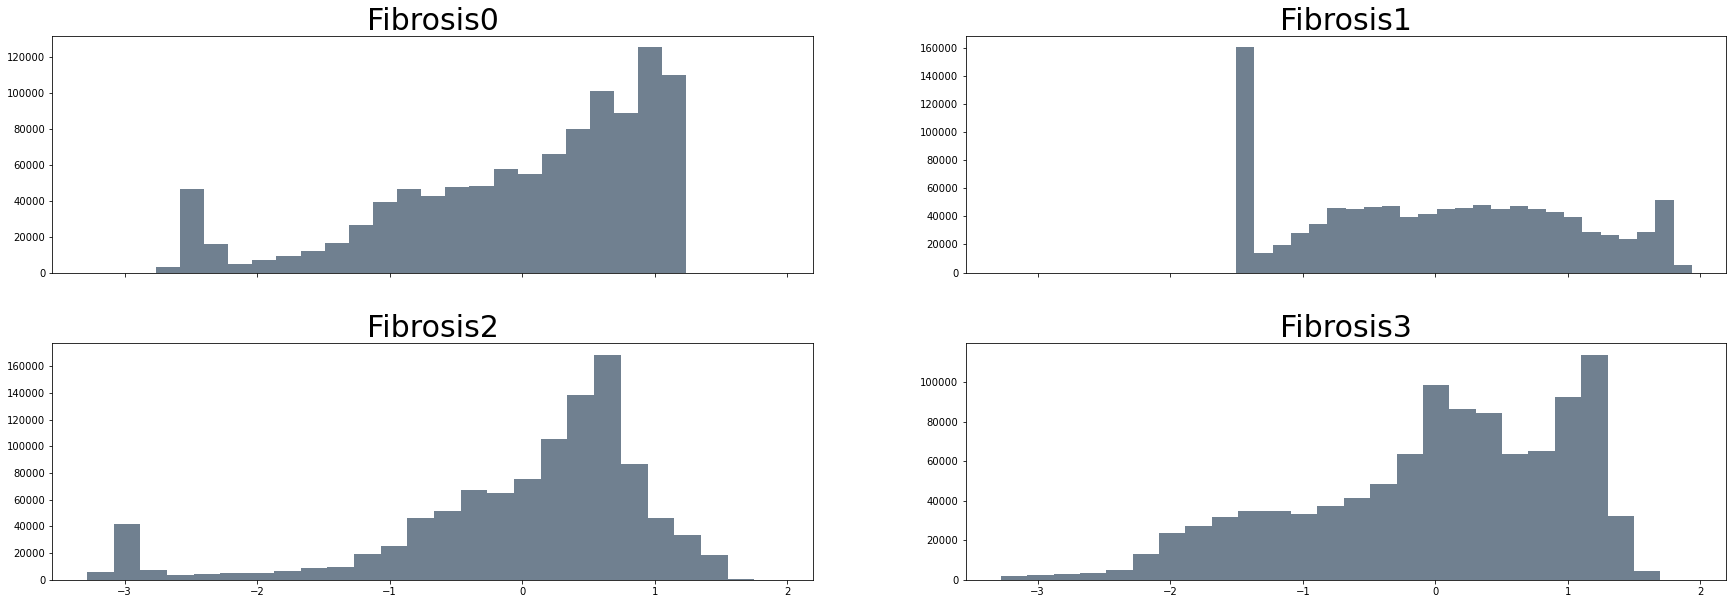

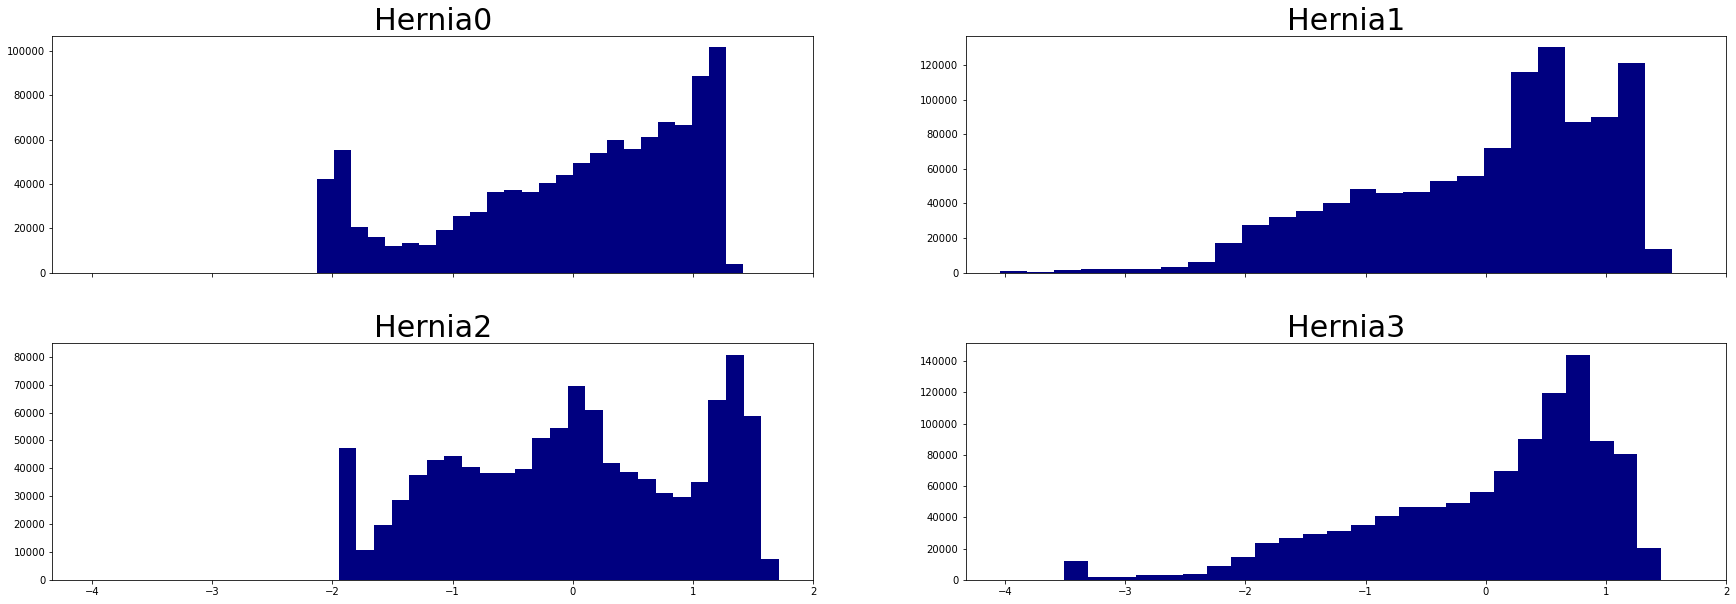

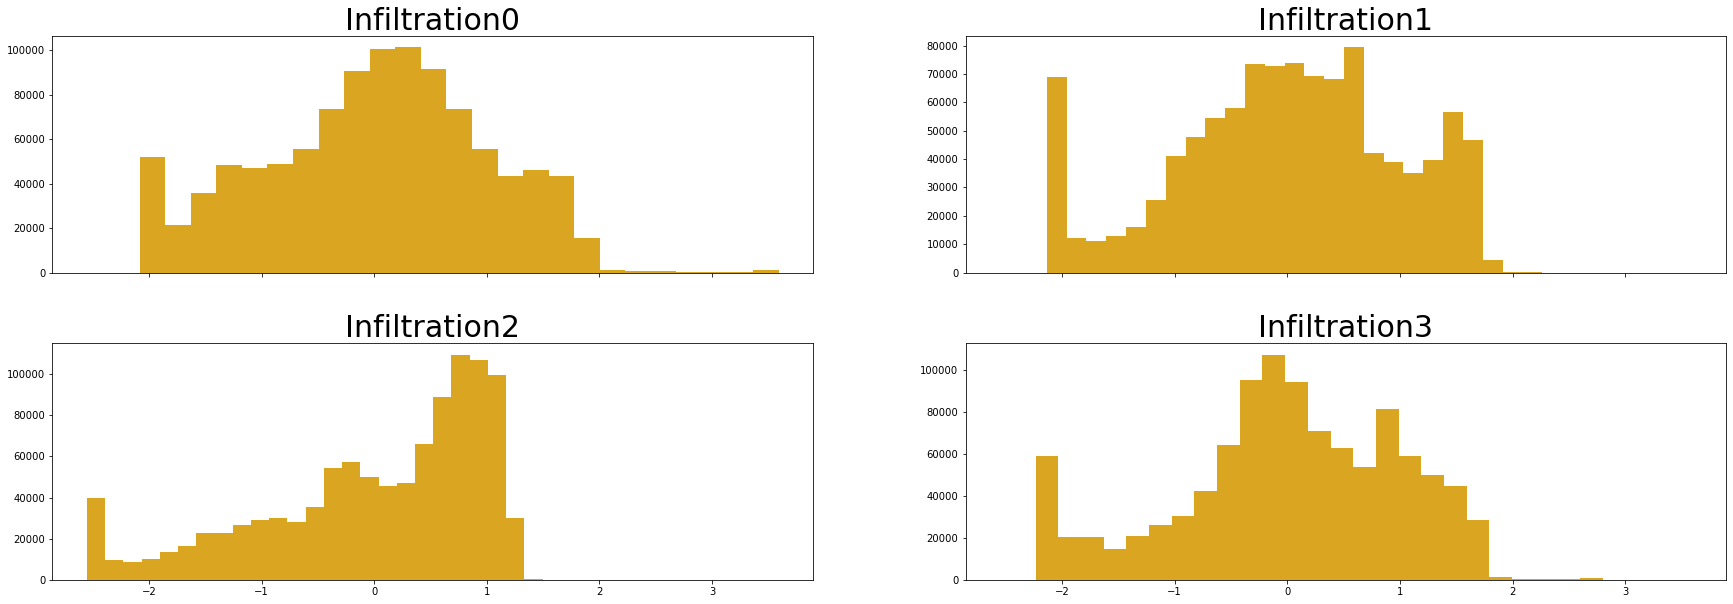

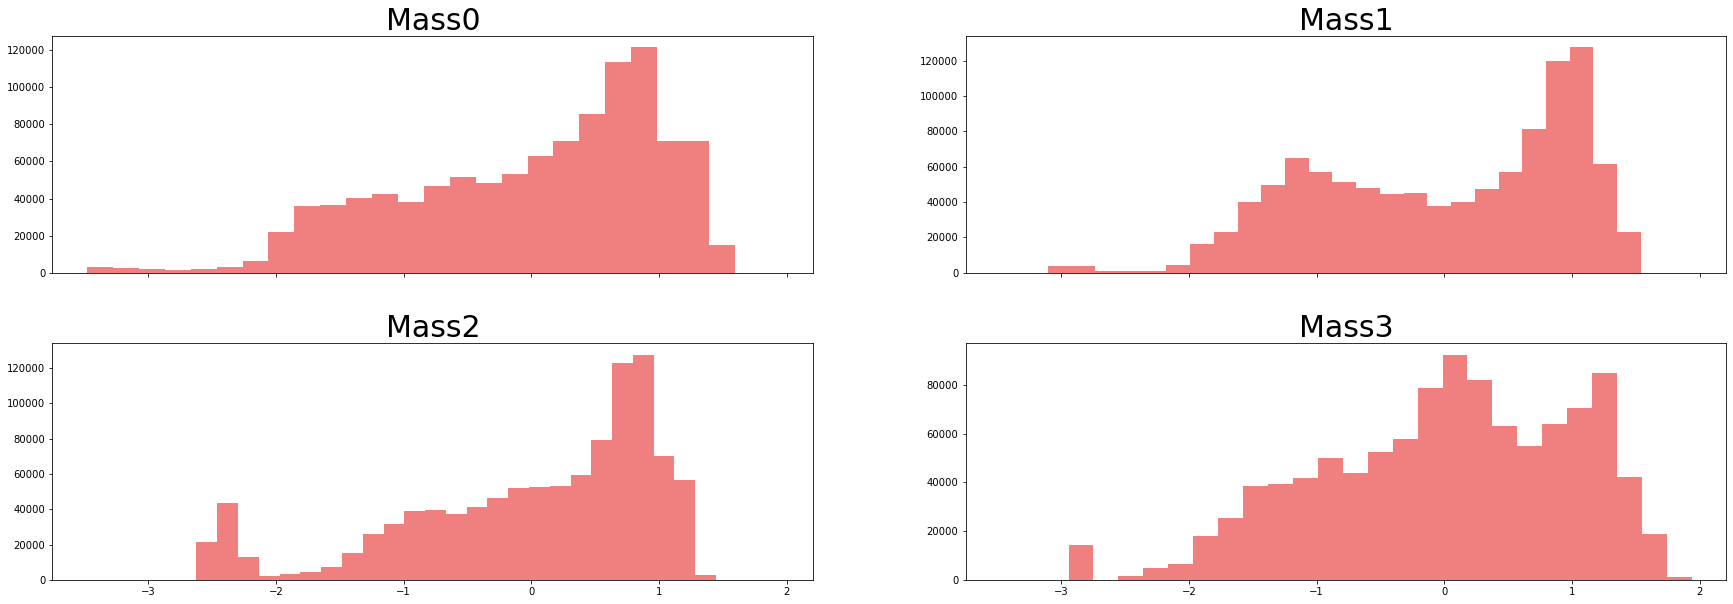

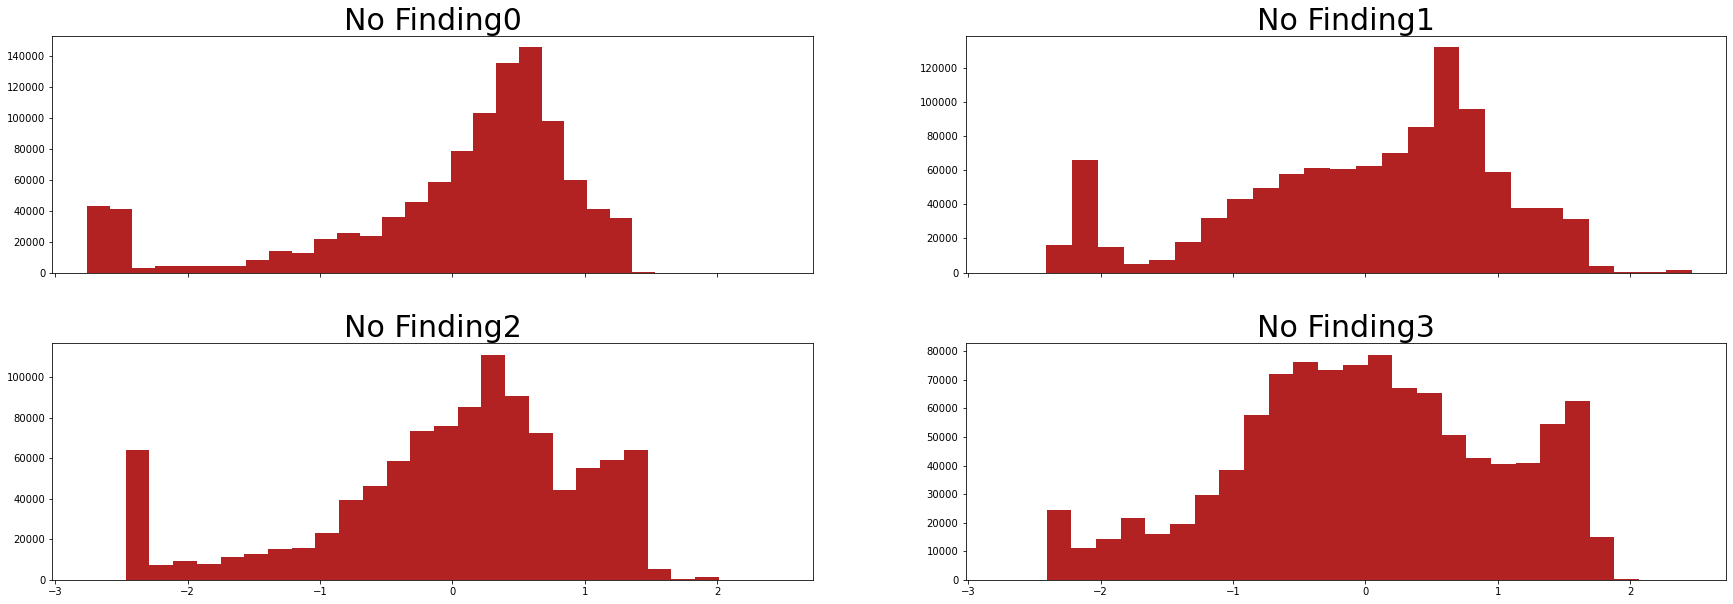

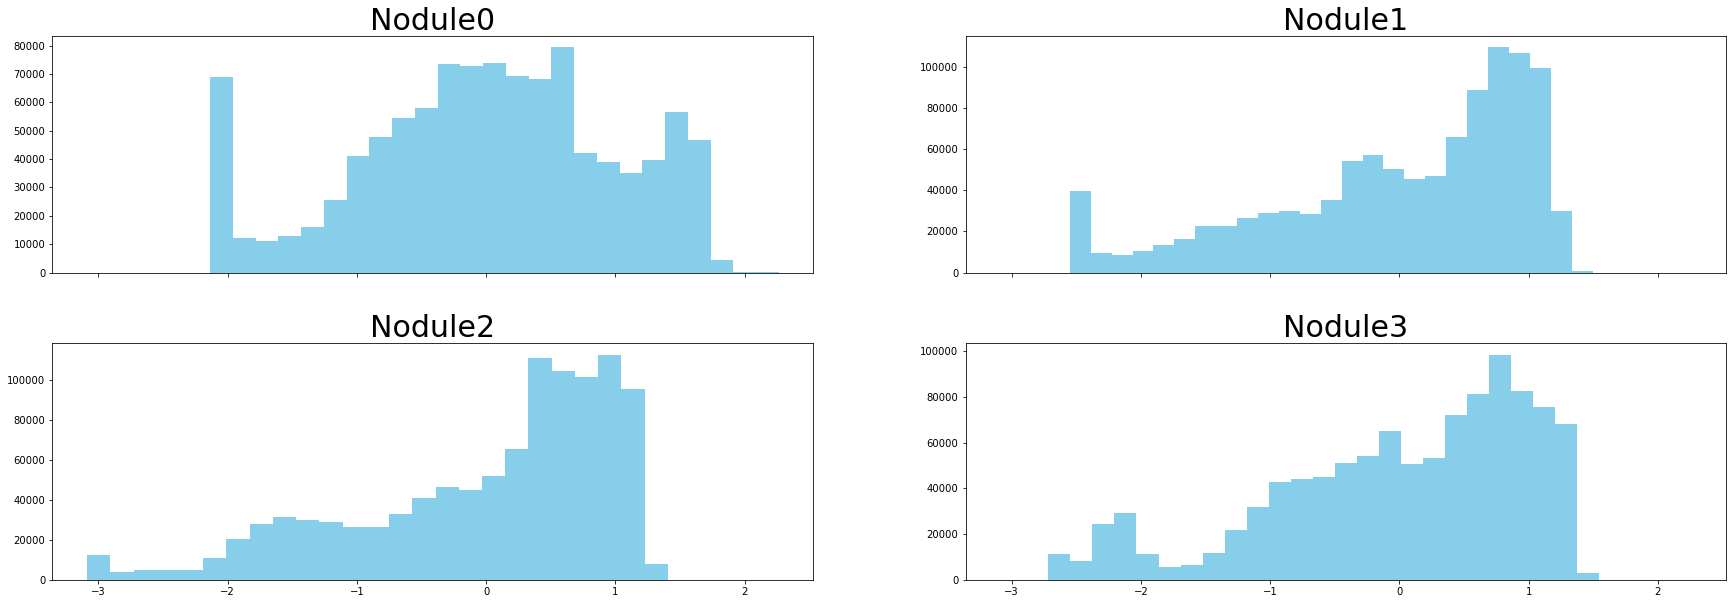

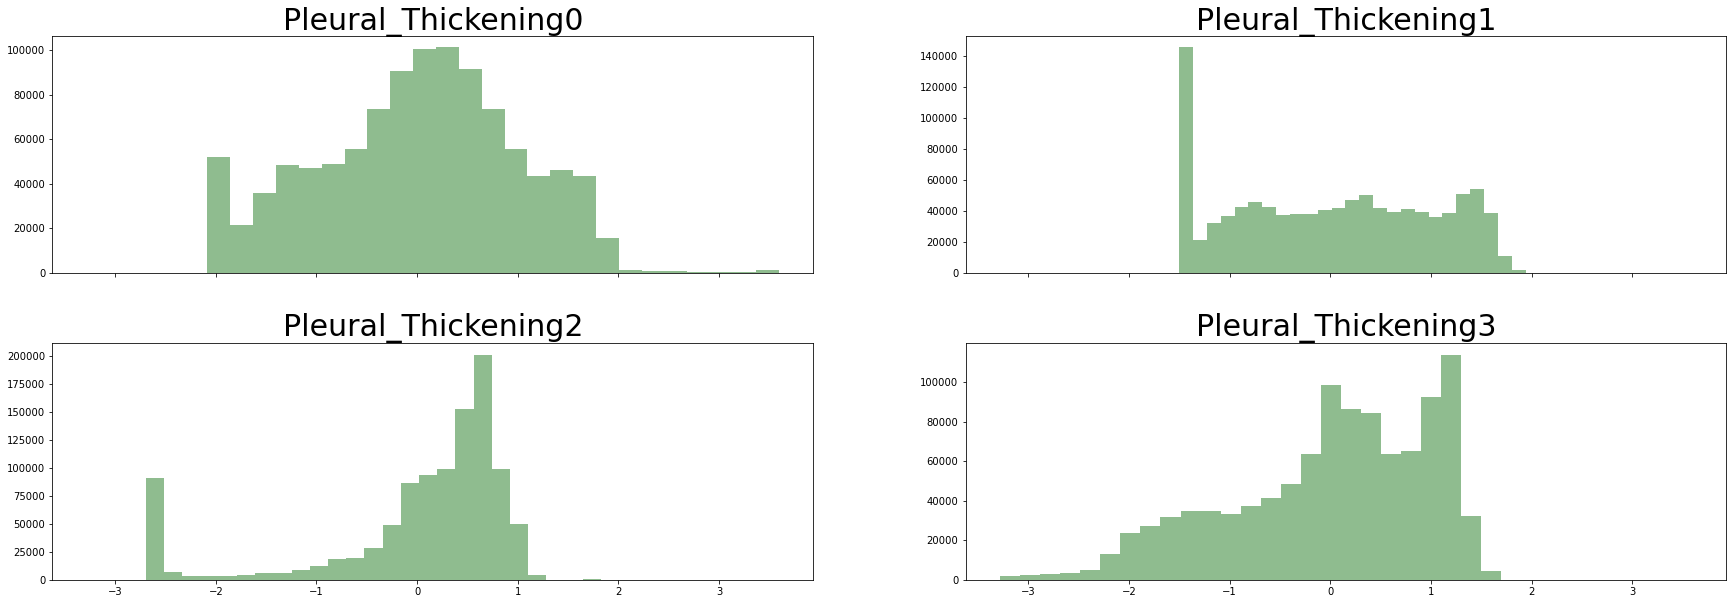

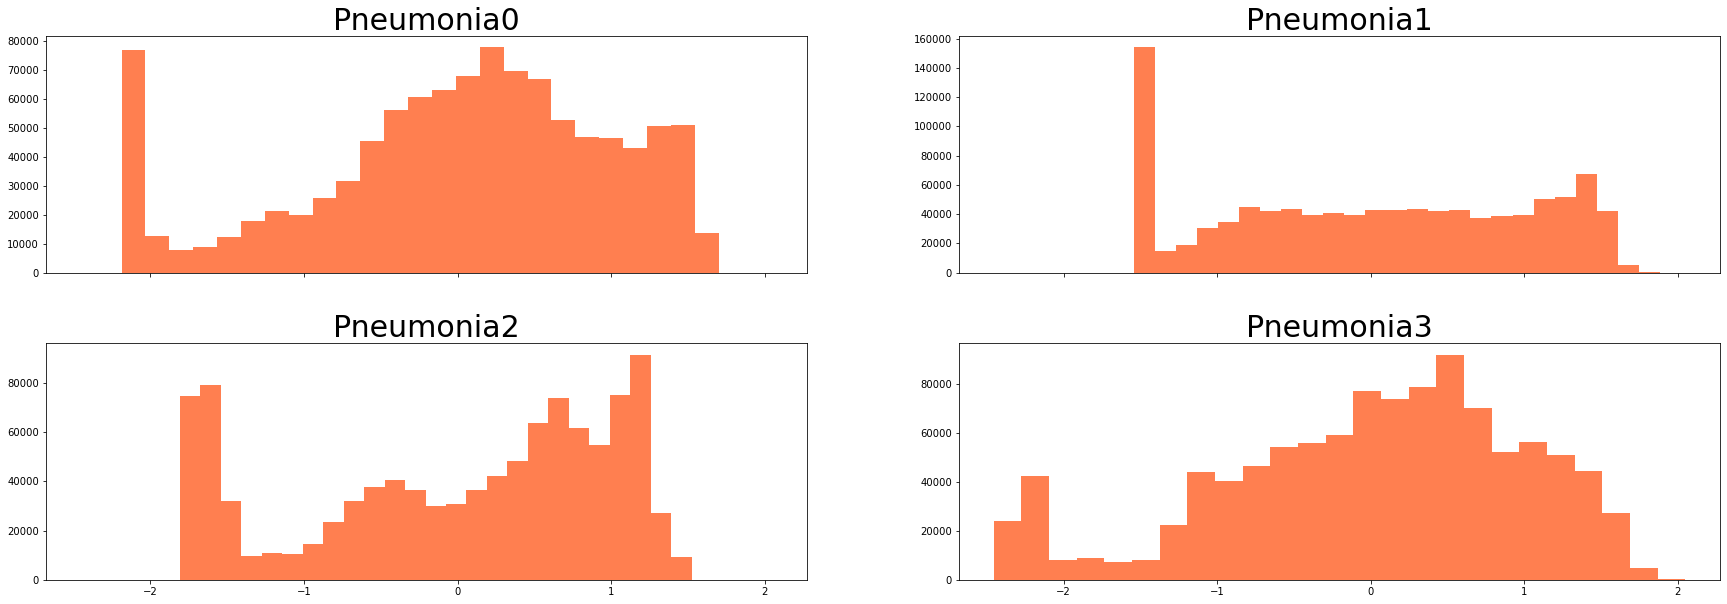

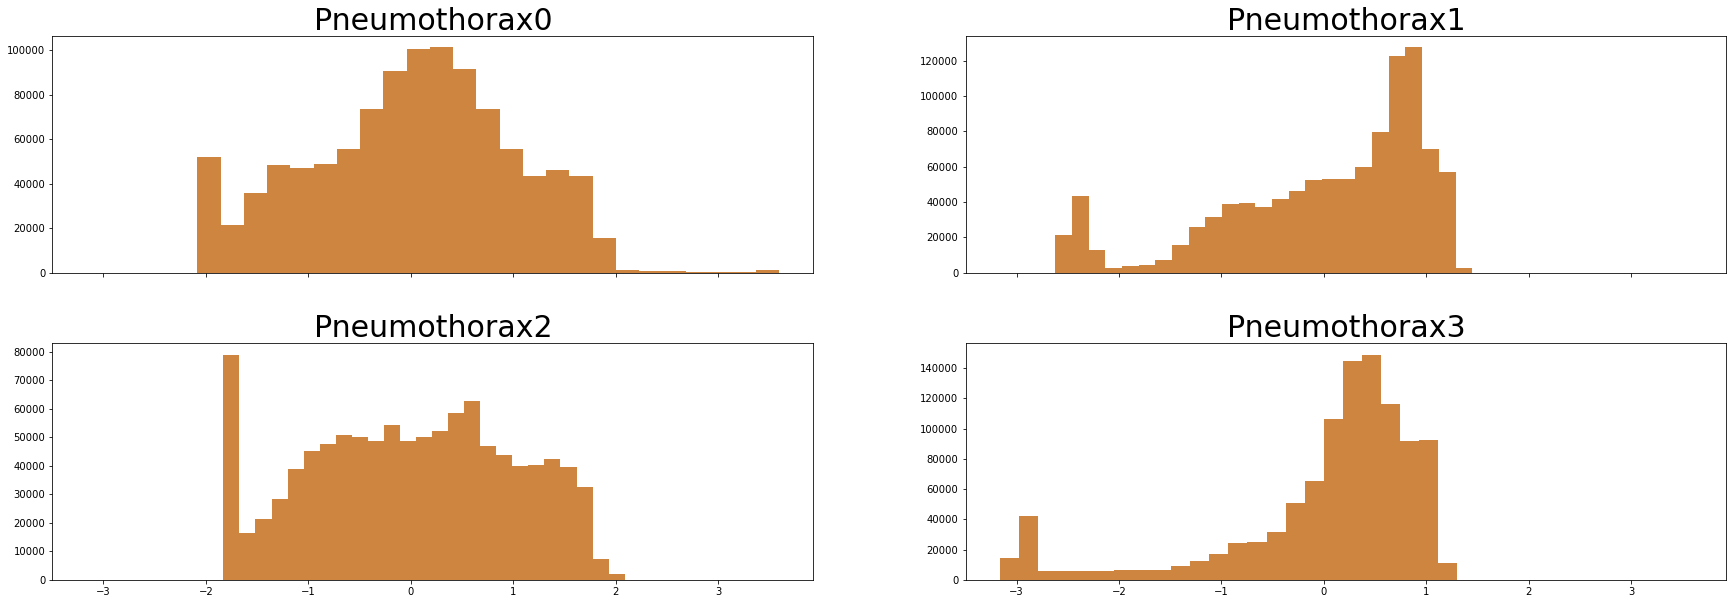

In [49]:
from itertools import cycle

from cycler import cycler

custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'darkorange', 
                               'forestgreen', 'slategrey', 'navy','goldenrod',
                               'lightcoral', 'firebrick', 'skyblue', 'darkseagreen', 'coral', 'peru']) +
                 cycler(lw=[1, 2, 3, 4,5, 6,7,8,9,10,11,12,13,14,15]))

for disease, col_obj in zip(all_labels, custom_cycler):

    fig, axs = plt.subplots(2, 2, figsize = (30, 10), sharey=False, sharex=True)
    axs = axs.flatten()
    ax_idx = 0

    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    col = 0  
   
    dftmp_plot = sample_df[sample_df[disease] == 1].copy()
    
    data = [i for i in dftmp_plot.head(4).path_img.values]
    
    for i in range(len(data)):
        axs[ax_idx].set_title(disease + "{}".format(i), fontsize = 30)
        img_set = plt.imread(data[i])
        
        axs[ax_idx].hist(((img_set - np.mean(img_set))/np.std(img_set)).ravel(), bins = 25, facecolor= col_obj["color"])
#         axs[ax_idx].set_prop_cycle(custom_cycler)
        ax_idx += 1

    fig.subplots_adjust(hspace = 0.3)

- Most of the images have a problem with zeros, It is probably due to the image is not centered, so there is a black border.
- Emphysema have a very different distributions from the other images.

----

### Dicoms

In [12]:
def get_df_dicom(label_image, initial, final):
    
    df_list = []
    
    for i in range(initial, final):
        dcm_obj = pydicom.dcmread("{}{}.dcm".format(label_image, i))
        df_tmp = pd.DataFrame({'patient_id':[dcm_obj.PatientID],
                     'patient_age':[dcm_obj.PatientAge],
                               'patient_sex':[dcm_obj.PatientSex],
                               'modality':[dcm_obj.Modality],
                               'type_finding':[dcm_obj.StudyDescription],
                               'rows':[dcm_obj.Rows],
                               'columns':[dcm_obj.Columns],
                               'pixel_array':[dcm_obj.pixel_array]
                              })
        df_list.append(df_tmp)
    dfpatients = pd.concat(df_list)
    
    return dfpatients

In [35]:
def plot_dicoms(df):

    fig, axs = plt.subplots(int(np.round(df.shape[0]/2,0).item()) , 2, figsize = (20, 30), sharey=False, sharex=True)
    axs = axs.flatten()
    ax_idx = 0
  
    
    
    for index, row in df.iterrows():
        
        dcm_obj = pydicom.dcmread("test{}.dcm".format(i))
        axs[ax_idx].set_title(row.type_finding, fontsize = 24)
        #     plt.hist(dcm_obj.pixel_array.ravel())
        axs[ax_idx].imshow(row.pixel_array, cmap="gray")
          
        ax_idx += 1
    plt.show();

In [13]:
dfpatienst = get_df_dicom("test", 1, 7)

In [37]:
dfpatienst.patient_id.unique()

array(['2', '1', '61'], dtype=object)

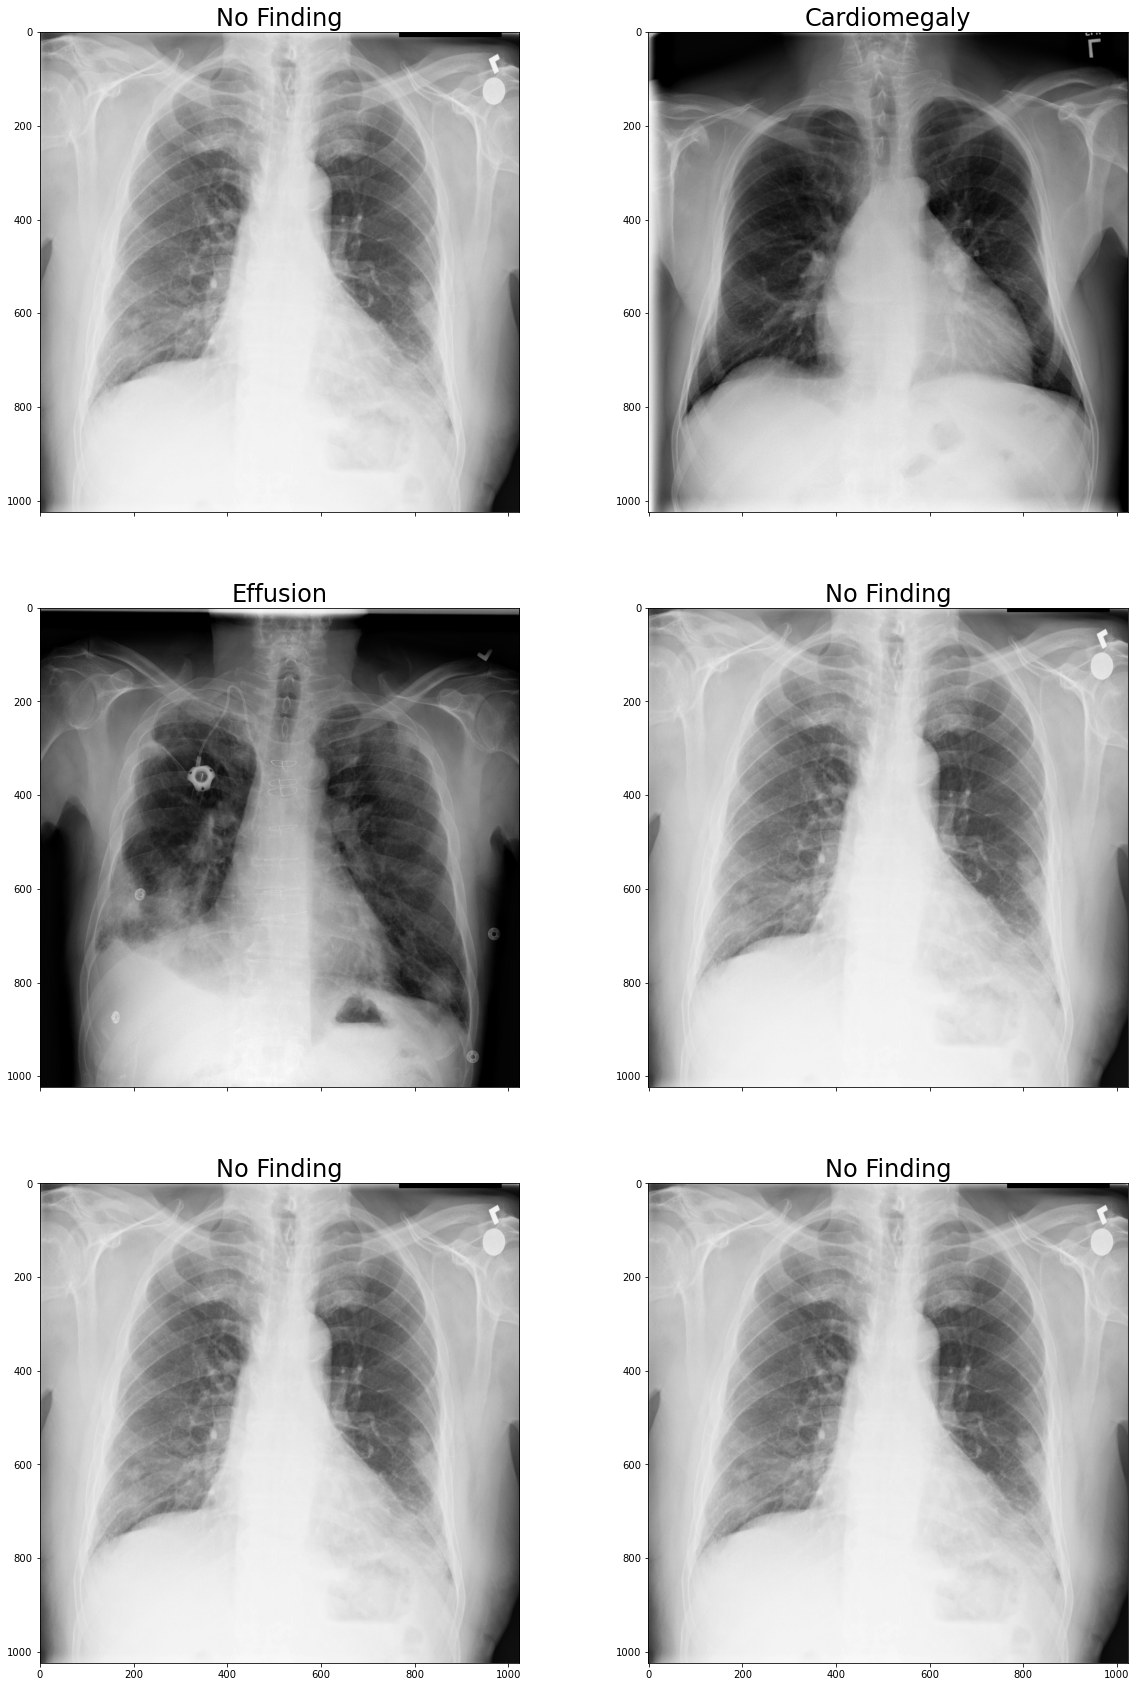

In [36]:
plot_dicoms(dfpatienst)

---